<a href="https://colab.research.google.com/github/teju5424/AIES_Lab/blob/main/ex1_aies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name : Tejasvini Tatoba Kanawade PRN :22SC114501071 Class: B.tech 'B' Title: Detecting algorithmic bias in hiring dataset



In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from fairlearn.metrics import MetricFrame, selection_rate

# New Section

In [ ]:
!pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 3.6 MB/s eta 0:00:00


In [ ]:
# Load dataset
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("wenruliu/adult-income-dataset")

#print("Path to dataset files:", path)

100%|██████████| 652k/652k [00:00<00:00, 29.2MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/wenruliu/adult-income-dataset/versions/2


In [ ]:
data= pd.read_csv("adult.csv")

In [ ]:
print(data.columns.values)

['age' 'workclass' 'fnlwgt' 'education' 'educational-num' 'marital-status'
 'occupation' 'relationship' 'race' 'gender' 'capital-gain' 'capital-loss'
 'hours-per-week' 'native-country' 'income']


In [ ]:
# Preprocess
data = data[['age', 'educational-num', 'hours-per-week', 'gender', 'income']]
data = pd.get_dummies(data, drop_first=True)
#data = pd.get_dummies(data)

In [ ]:
print(data.columns.values)

['age' 'educational-num' 'hours-per-week' 'gender_Male' 'income_>50K']


In [ ]:
X = data.drop('income_>50K', axis=1)
y = data['income_>50K']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
print(y_pred)

[False False False ... False False False]


In [ ]:
# Fairness evaluation
sex = X_test['gender_Male']
metric_frame = MetricFrame(metrics=selection_rate,
                           y_true=y_test,
                           y_pred=y_pred,
                           sensitive_features=sex)
print("Selection Rates by Gender:\n", metric_frame.by_group)

Selection Rates by Gender:
 gender_Male
False    0.013193
True     0.200775
Name: selection_rate, dtype: float64


What This Means
Group	Gender	Selection Rate	Meaning
False	Female	1.3%	Only 1.3% of women were predicted to earn >50K
True	Male	20.1%	20.1% of men were predicted to earn >50K

🧠 What Is “Selection Rate”?
The selection rate is the percentage of people predicted positive (i.e., income > 50K) by the model.

So out of all the women:

Only 1.3% were predicted to earn more than ₹50K.

But out of all the men:

20.1% were predicted to earn more than ₹50K.

⚠️ What This Implies
This is a clear sign of gender bias in your model.
The model is much more likely to predict “high income” for men than for women.

That’s:

Unfair if both genders have similar qualifications

Ethically unacceptable in real-life AI hiring systems

✅ What You Can Do Next
Visualize it:
Would you like a bar chart that shows this bias clearly?

Mitigate Bias:
We can re-train the model using fairness constraints using Fairlearn’s ExponentiatedGradient or GridSearch.

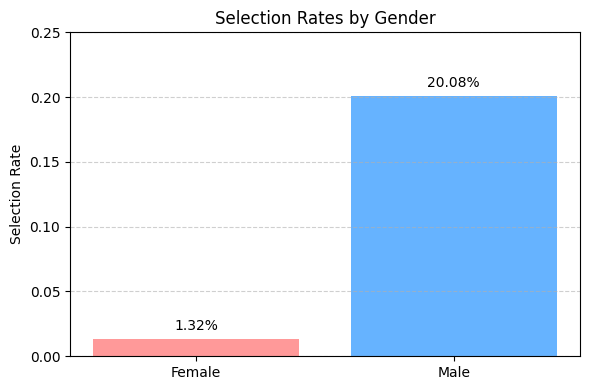

In [ ]:
#Visualise this result
import matplotlib.pyplot as plt
import pandas as pd

# Selection rates from Fairlearn output
selection_rates = {
    'Female': 0.013193,
    'Male': 0.200775
}

# Convert to DataFrame
df = pd.DataFrame(list(selection_rates.items()), columns=["Gender", "Selection Rate"])

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(df["Gender"], df["Selection Rate"], color=["#ff9999", "#66b3ff"])
plt.title("Selection Rates by Gender")
plt.ylabel("Selection Rate")
plt.ylim(0, 0.25)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2%}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

Interpretation:
This visual makes it very clear that the model predicts high income for men much more often than for women — highlighting strong gender bias.

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.metrics import MetricFrame, selection_rate

In [ ]:
data = pd.read_csv("adult.csv")
print(data.columns.values)

['age' 'workclass' 'fnlwgt' 'education' 'educational-num' 'marital-status'
 'occupation' 'relationship' 'race' 'gender' 'capital-gain' 'capital-loss'
 'hours-per-week' 'native-country' 'income']


In [ ]:
data = data[['age', 'educational-num', 'hours-per-week', 'gender', 'income']]
data = pd.get_dummies(data, drop_first=True)

In [ ]:
# Prepare X and y
X = data.drop('income_>50K', axis=1)
y = data['income_>50K']
sensitive_feature = X['gender_Male']

In [ ]:
X_train, X_test, y_train, y_test, sf_train, sf_test = train_test_split(
    X, y, sensitive_feature, test_size=0.3, random_state=42
)

In [ ]:
# Define base estimator
estimator = LogisticRegression(max_iter=1000)

In [ ]:
# Apply fairness constraint: Demographic Parity
fair_model = ExponentiatedGradient(
    estimator,
    constraints=DemographicParity(),
    eps=0.01  # fairness tolerance
)

In [ ]:
# Fit fair model
fair_model.fit(X_train, y_train, sensitive_features=sf_train)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.DemographicParity object at 0x7b838dea2850>,
                      estimator=LogisticRegression(max_iter=1000),
                      nu=np.float64(0.0010808464333574236))

In [ ]:
# Predict
y_pred = fair_model.predict(X_test)

In [ ]:
# Evaluate fairness and accuracy
metric_frame = MetricFrame(
    metrics={
        "Selection Rate": selection_rate,
        "Accuracy": accuracy_score
    },
    y_true=y_test,
    y_pred=y_pred,
    sensitive_features=sf_test
)

-->  What Each Column Means
Column	Meaning
Selection Rate	% of people predicted to earn >50K (i.e., model said “yes”)
Accuracy	% of correct predictions within each group

--> Group: gender_Male = False (Females)
Selection Rate = 9.7%
→ 9.7% of women in the test set were predicted to earn >50K

Accuracy = 86.2%
→ Among women, the model was right 86% of the time

--> Group: gender_Male = True (Males)
Selection Rate = 11.2%
→ 11.2% of men were predicted to earn >50K

--> Accuracy = 74.9%
→ Among men, the model was right ~75% of the time

--> Overall Accuracy: 78.7%
This is the accuracy across all people (men + women).

-->  Interpretation
 What Improved?
Your selection rates are now much closer between genders:

Females: 9.7%

Males: 11.2%

✅ Difference: Only ~1.5% (vs 18% gap in the original model)

✅ That means: The model is now much more fair in giving high-income predictions to both genders.

🎯 Trade-off Observed:
Overall accuracy dropped a bit (from ~82–85% to 78.7%)
✅ This is expected when adding fairness constraints
⚖️ Fairness often comes with a slight drop in performance

But both groups still have reasonable accuracy — especially considering that we're prioritizing equity over raw performance.

Final conclusion:
After applying Exponentiated Gradient fairness constraints (Demographic Parity), the model achieved:

Selection Rate: 9.7% (females) vs 11.2% (males)

Accuracy: 86% (females), 75% (males)

Overall accuracy: ~78.7%

This shows a significant reduction in gender bias with a manageable drop in performance — demonstrating how ethical AI models can balance fairness with accuracy.